### this is the prep for the CFS4 model

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import re
import os
import sys
import shutil
from shutil import copyfile, copy2
from shutil import move

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from scipy import stats
# Cause plots to be displayed in the notebook:
%matplotlib inline

In [3]:
import subprocess 

In [4]:
from matplotlib import cm
from latt2D_modules import calc_diffuse_cfs4, calc_diffuse_cfs4_big,recalc_diff_from_other_cfs4_big
from latt2D_modules import get_occ_map, get_2D_occ_map_from_seq,store_occ_map_as_seq
from latt2D_modules import plot_occ_map,read_bin,output_16bit_pgm
import time

In [5]:
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [41]:

iconc=0.50 # spin concentration
cread=0    # reading correlation function from input file  otherwise it will be generated randomly 
'corr.in'
'jswitch.in'
icycles=300  # MC cycles 
ianneal=300  # MC input 


corrin=np.array([[1.0, 0.0, 0.0, 0.0], 
                 [0.0, 0.0, 0.0, 0.0],
                 [0.0, 0.0, 0.0, 0.0],
                 [0.0, 0.0, 0.0, 0.0]])

fhout=open('corr.in','w')
fhout.write("%.6f %.6f %.6f %.6f\n%.6f %.6f %.6f %.6f\n%.6f %.6f %.6f %.6f\n%.6f %.6f %.6f %.6f\n"%(tuple(corrin.flatten())))
fhout.close()

jsw=np.ones((16)) 
        

fhout=open('jswitch.in','w')
fhout.write("%d %d %d %d\n%d %d %d %d\n%d %d %d %d\n%d %d %d %d\n"%tuple(jsw))
fhout.close()




In [ ]:
### Do a Preliminary test 
### generate as random image

In [66]:
calc_diffuse_cfs4(iconc,cread,icycles,ianneal,exp_no=0)
# store_occ_map_as_seq('./expfiles_0/ising2D_occ.txt','./expfiles_0/ising2D_seq.dat')

Correlation function configuration


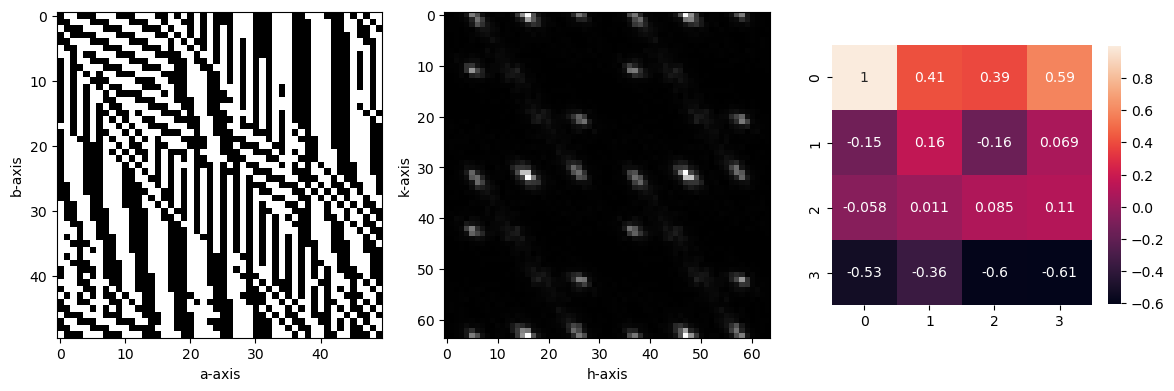

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))
occ3D=get_occ_map('./expfiles_0/ising2D_occ.txt')
store_occ_map_as_seq('./expfiles_0/ising2D_occ.txt','./expfiles_0/ising2D_seq.dat')
axes[0].imshow(np.transpose(occ3D[:,:,0]),interpolation='nearest',cmap='gray') 
axes[0].set_xlabel('a-axis')
axes[0].set_ylabel('b-axis')
imdat = read_bin('./expfiles_0/hk0.bin', npixels=64, offset=1280)
axes[1].imshow(np.flip(imdat,0),cmap='gray')
axes[1].set_xlabel('h-axis')
axes[1].set_ylabel('k-axis')
corr_out=np.loadtxt('expfiles_0/corr.out')
print("Correlation function configuration")
sns.heatmap(corr_out,ax=axes[2],annot=True,square=True,cbar_kws={'shrink':0.75})
plt.tight_layout()
# print(" 00: %.3f  01: %.3f  02: %.3f  03: %.3f\n 10: %.3f  11: %.3f  12: %.3f  13: %.3f\n 20: %.3f  21: %.3f  22: %.3f 23: %.3f \n 30: %.3f  31: %.3f  32: %.3f 33: %.3f \n"%tuple(corr_out.flatten()))

#### below is a check to see how the reinput changes - in future we can check using a few differnt metrics 
#### but for the time being the correlation function will act as the decoder for generating the crystal  

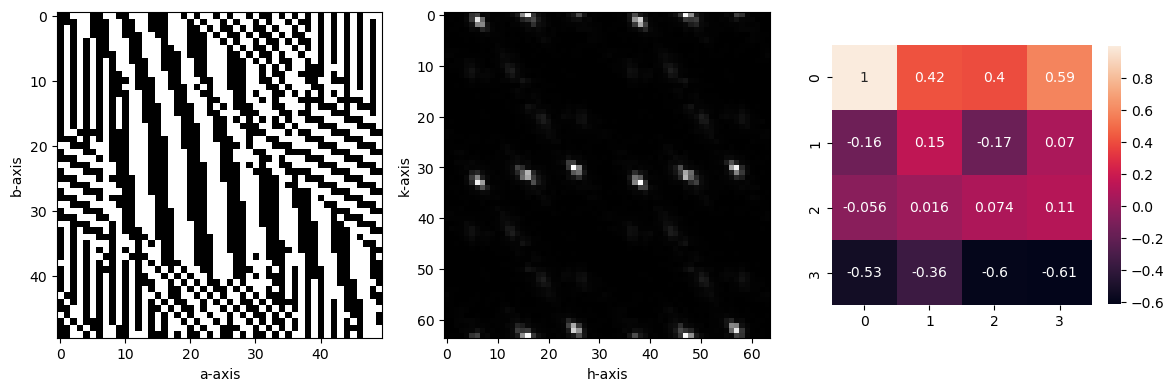

In [68]:
copyfile('expfiles_0/corr.out','./corr.in')
calc_diffuse_cfs4(iconc,1,icycles,ianneal,1)
store_occ_map_as_seq('./expfiles_1/ising2D_occ.txt','./expfiles_1/ising2D_seq.dat')
fig, axes = plt.subplots(1, 3, figsize=(12,4))
occ3D=get_occ_map('./expfiles_1/ising2D_occ.txt')
axes[0].imshow(np.transpose(occ3D[:,:,0]),interpolation='nearest',cmap='gray') 
axes[0].set_xlabel('a-axis')
axes[0].set_ylabel('b-axis')
imdat = read_bin('./expfiles_1/hk0.bin', npixels=64, offset=1280)
axes[1].imshow(np.flip(imdat,0),cmap='gray')
axes[1].set_xlabel('h-axis')
axes[1].set_ylabel('k-axis')
corr_out=np.loadtxt('expfiles_1/corr.out')
sns.heatmap(corr_out,ax=axes[2],annot=True,square=True,cbar_kws={'shrink':0.75})
plt.tight_layout()
# print(" 00: %.3f  01: %.3f  02: %.3f  03: %.3f\n 10: %.3f  11: %.3f  12: %.3f  13: %.3f\n 20: %.3f  21: %.3f  22: %.3f 23: %.3f \n 30: %.3f  31: %.3f  32: %.3f 33: %.3f \n"%tuple(corr_out.flatten()))

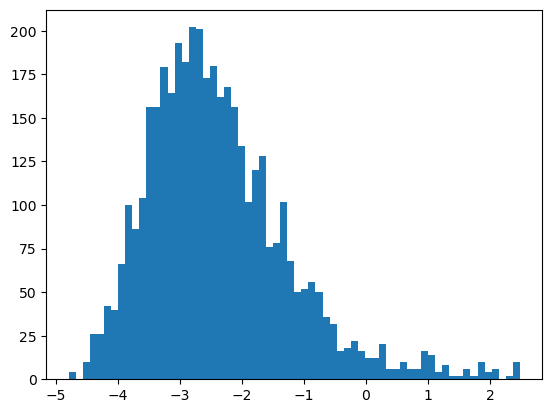

In [71]:
ax=plt.hist(np.log(imdat.flatten()),bins=64,density=False,)

### Lets calculate an accuracy and MSE for the correaltion functions as well as the images 
### we will use this as a modified baseline accuracy since the binary grid will also have intrinsic baseline acc 

In [20]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

In [45]:
occ2D_0=get_2D_occ_map_from_seq('./expfiles_0/ising2D_seq.dat')
occ2D_1=get_2D_occ_map_from_seq('./expfiles_1/ising2D_seq.dat')
accuracy=sum(occ2D_0==occ2D_1)/len(occ2D_0.flatten())
print("Ising2D accuracy:", accuracy)
corr_out_0=np.loadtxt('expfiles_0/corr.out')
corr_out_1=np.loadtxt('expfiles_1/corr.out')
imdat_0 = read_bin('./expfiles_0/hk0.bin', npixels=64, offset=1280)
imdat_1 = read_bin('./expfiles_1/hk0.bin', npixels=64, offset=1280)
print("MSE correlation config: ", mean_squared_error(corr_out_0.flatten(),corr_out_1.flatten()))
print("MSE FT images: ", mean_squared_error(imdat_0.flatten(),imdat_1.flatten()))

Ising2D accuracy: [0.0084 0.0072 0.0104 0.0096 0.0092 0.0092 0.0116 0.0096 0.01   0.0124
 0.0112 0.0092 0.0128 0.0092 0.0088 0.0104 0.0104 0.0076 0.0104 0.0096
 0.0096 0.01   0.01   0.0092 0.01   0.0108 0.008  0.008  0.0104 0.0076
 0.0076 0.0104 0.0076 0.0076 0.0088 0.0092 0.0092 0.0096 0.0088 0.0096
 0.0092 0.008  0.0092 0.0072 0.006  0.0084 0.01   0.008  0.0084 0.0108]
MSE correlation config:  0.00047233708900000016
MSE FT images:  0.13167945


## The below cell will generate random images which can be used for training a CNN
## The correlations are stored in a dataframe which is then saved as a .csv 

In [46]:
# %%timeit # you need to be careful with this becasue magic function acts like wrapper and screws with variable locality
# in fact its running the loop several times to get an average - if you want the time for a single run just import time
iconc=0.50 # spin concentration
cread=0    # reading correlation function from input file  otherwise it will be generated randomly 
icycles=300  # MC cycles 
ianneal=300  # MC input 

start_time = time.time()
# when possible always dump to a list or array before converting to Dataframe
N=5000 # make this many images
Nstart=0 # start labels here
corrfuncs=[]
for i in range(N):
    k=i+Nstart
    calc_diffuse_cfs4(iconc,0,icycles,ianneal,exp_no=0)
    copyfile('./expfiles_0/hk0.bin','./cfs4_image_inputs_bin/hk0_%s.bin'% str(k).zfill(6))
    store_occ_map_as_seq('./expfiles_0/ising2D_occ.txt','./cfs4_image_inputs_seq/ising2D_seq_%s.dat' %  str(k).zfill(6))
    # dont save the full occfile unless needed - since this takes up resources 
    # copyfile('./expfiles_0/ising2D_occ.txt','./image_inputs_occ/ising2D_occ_%d.txt'%(i))  
    corr_out=np.loadtxt('expfiles_0/corr.out')
    corrfuncs.append(corr_out.flatten())
    
end_time = time.time()
total_time = end_time - start_time

print("Total time taken: {:.2f} seconds".format(total_time))

Total time taken: 6523.26 seconds


### dont forget to relabel the DF if you are making a new batch
for 5000 images Total time taken: 4799.41 seconds

In [47]:
df=pd.DataFrame(corrfuncs)
df.columns=['00','01','02','03','10','11','12','13','20','21','22','23','30','31','32','33']
df.to_csv('output_correlations_cfs4_5000.csv')
df.head()

,00,01,02,03,10,11,12,13,20,21,22,23,30,31,32,33
0,0.999997,-0.128003,0.379197,0.369597,0.070397,0.159997,-0.379203,0.454397,-0.020803,-0.204803,-0.294403,-0.153603,-0.084803,0.454397,-0.144003,0.283197
1,0.999690,-0.285110,-0.334710,0.180490,-0.008310,0.201290,-0.374710,0.236490,-0.502710,-0.085110,0.274890,0.082890,0.178890,-0.173110,0.294090,-0.257910
2,0.998335,0.036735,0.239935,0.411135,-0.177665,-0.011265,-0.044865,0.070335,0.311935,0.126335,0.486335,-0.091265,-0.228865,-0.329665,-0.230465,0.041535
3,0.999124,-0.210476,0.171924,0.219924,0.186324,-0.164076,-0.229676,0.264724,0.072724,-0.615276,0.187924,-0.255276,-0.317676,-0.138476,-0.084076,0.119124
4,0.999948,-0.216052,-0.171252,0.271948,-0.096052,0.156748,0.243148,-0.564852,0.235148,-0.116852,0.119948,-0.145652,-0.528052,0.398348,-0.120052,-0.393652


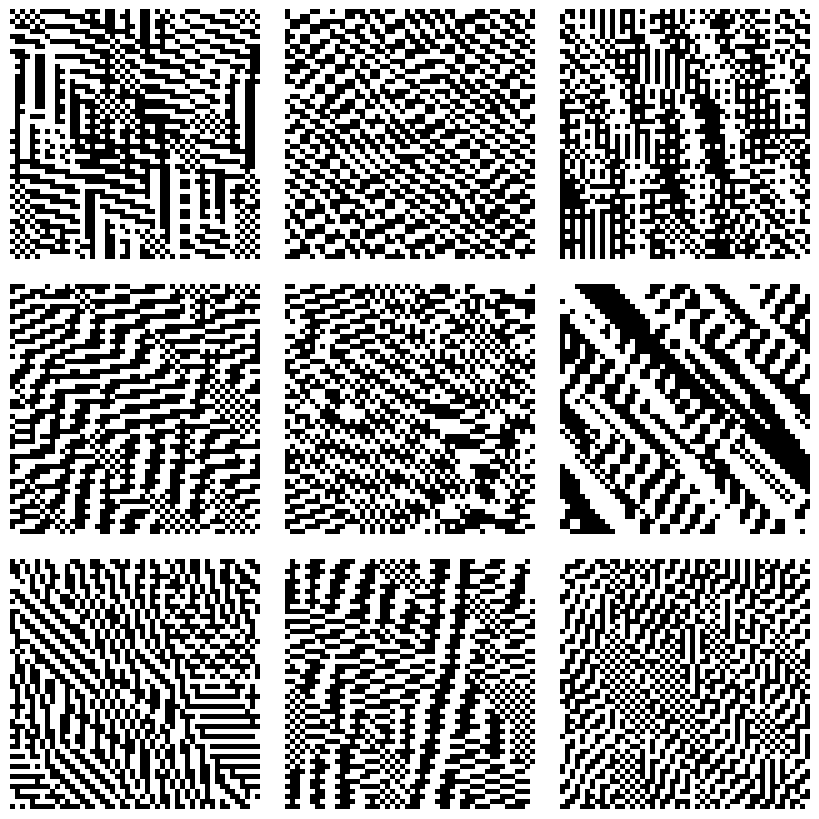

In [6]:
rows,cols =3,3 
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
Nstart=0 # start labels here
k=0
for i in range(rows): 
    for j in range(cols):
        # occ3D=get_occ_map('./image_inputs_occ/ising2D_occ_%d.txt'%(k))
        # axes[i,j].imshow(np.transpose(occ3D[:,:,0]),interpolation='nearest',cmap=my_cmap) 
        occ2D=get_2D_occ_map_from_seq('./cfs4_image_inputs_seq/ising2D_seq_%s.dat'%str(k+Nstart).zfill(6))
        axes[i,j].imshow(np.transpose(occ2D),interpolation='nearest',cmap='gray') 
        axes[i,j].axis('off')
        # axes[i,j].set_xlabel('a-axis')
       # axes[i,j].set_ylabel('b-axis')

        k+=1

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.1)


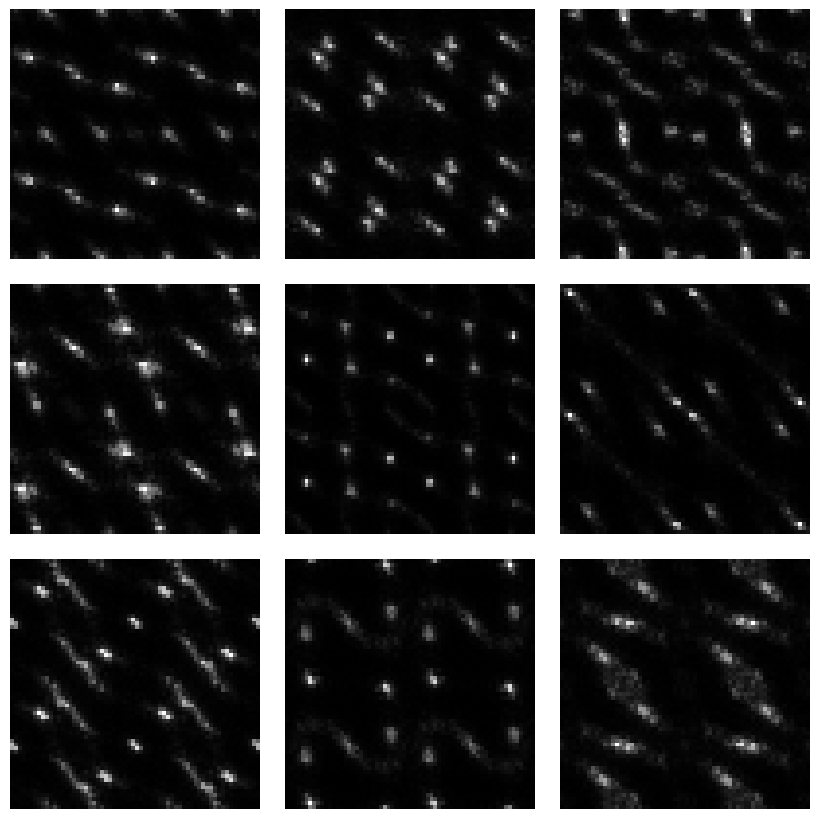

In [7]:
rows,cols =3,3 
fig, axes = plt.subplots(rows, cols, figsize=(10,10))
Nstart=0 # start labels here
k=0
for i in range(rows): 
    for j in range(cols):
        imdat = read_bin('./cfs4_image_inputs_bin/hk0_%s.bin'%str(k+Nstart).zfill(6), npixels=64, offset=1280)
        axes[i,j].imshow(np.flip(imdat,0),cmap='gray')
        axes[i,j].set_xlabel(None)
        axes[i,j].axis('off')
        k+=1

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.1,
                    hspace=0.1)

In [48]:
# save the data as .h5

import h5py

# Set the path to your images directory
img_dir = "./cfs4_image_inputs_bin/"

# Set the size of your images
img_size = (64, 64)

# Set the path to where you want to save the HDF5 file
h5_file = "./cfs4_image_dataset_5000.h5"

nfiles=5000
Nstart=0 
# Create a new HDF5 file
with h5py.File(h5_file, 'w') as hf:

    # Create a dataset to store your image data
    img_data = hf.create_dataset('cfs4_img_data', shape=(nfiles, *img_size), dtype=np.float64)

    # Loop through each image file
    for i in range(nfiles):    
        
        # Convert the image to a numpy array
        img_arr =read_bin(img_dir+'hk0_%s.bin'%str(i+Nstart).zfill(6), npixels=64, offset=1280)
        
        # Store the image data in the dataset
        img_data[i] = img_arr

# Print a message indicating the dataset has been created
print("Dataset created in {}".format(h5_file))


Dataset created in ./cfs4_image_dataset_5000.h5


In [20]:
# Open the HDF5 file in read-only mode
with h5py.File('image_dataset_1000.h5', 'r') as f:
    # Get a list of dataset names in the HDF5 file
    dataset_names = list(f.keys())
    
    # Print the names of all datasets
    for name in dataset_names:
        print(name)
    dset=f['img_data']
    X=dset[:]

img_data


## generate some better quality FT using a larger simulation  

In [72]:

iconc=0.50 # spin concentration
cread=0    # reading correlation function from input file  otherwise it will be generated randomly 
icycles=500  # MC cycles 
ianneal=500  # MC input 


# generate a random image using cfs4_big

In [73]:
calc_diffuse_cfs4_big(iconc,cread,icycles,ianneal,exp_no=0)
# store_occ_map_as_seq('./expfiles_0/ising2D_occ.txt','./expfiles_0/ising2D_seq.dat')

Correlation function configuration


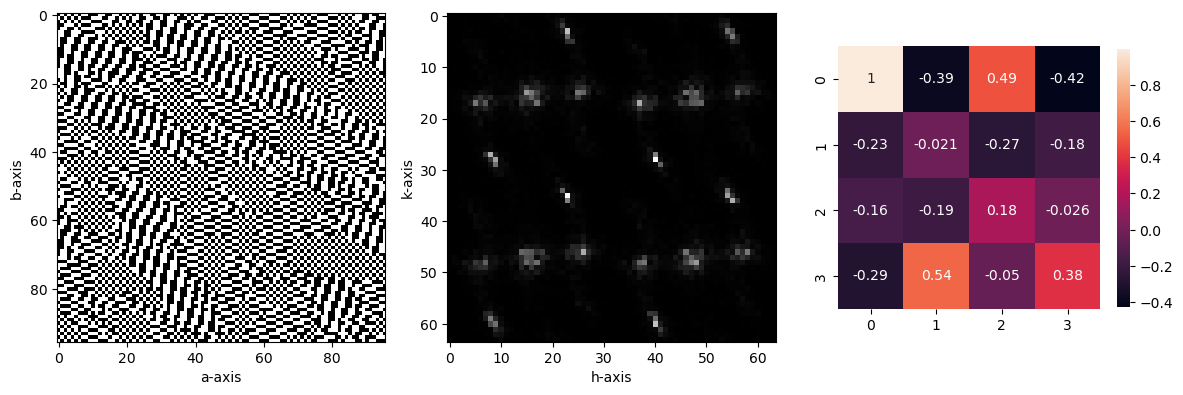

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))
occ3D=get_occ_map('./expfiles_0/ising2D_occ.txt')
store_occ_map_as_seq('./expfiles_0/ising2D_occ.txt','./expfiles_0/ising2D_seq.dat')
axes[0].imshow(np.transpose(occ3D[:,:,0]),interpolation='nearest',cmap='gray') 
axes[0].set_xlabel('a-axis')
axes[0].set_ylabel('b-axis')
imdat = read_bin('./expfiles_0/hk0.bin', npixels=64, offset=1280)
axes[1].imshow(np.flip(imdat,0),cmap='gray')
axes[1].set_xlabel('h-axis')
axes[1].set_ylabel('k-axis')
corr_out=np.loadtxt('expfiles_0/corr.out')
print("Correlation function configuration")
sns.heatmap(corr_out,ax=axes[2],annot=True,square=True,cbar_kws={'shrink':0.75})
plt.tight_layout()
# print(" 00: %.3f  01: %.3f  02: %.3f  03: %.3f\n 10: %.3f  11: %.3f  12: %.3f  13: %.3f\n 20: %.3f  21: %.3f  22: %.3f 23: %.3f \n 30: %.3f  31: %.3f  32: %.3f 33: %.3f \n"%tuple(corr_out.flatten()))

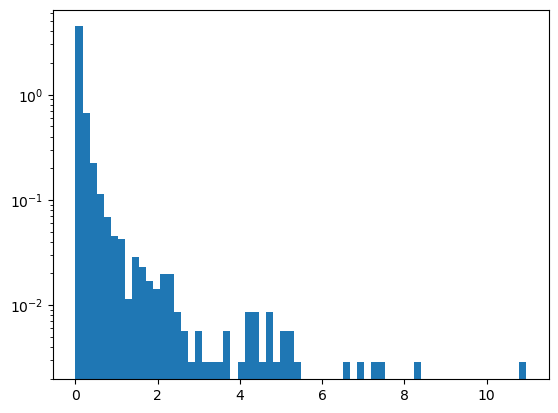

In [75]:
ax=plt.hist(imdat.flatten(),bins=64,density=True,log=True)

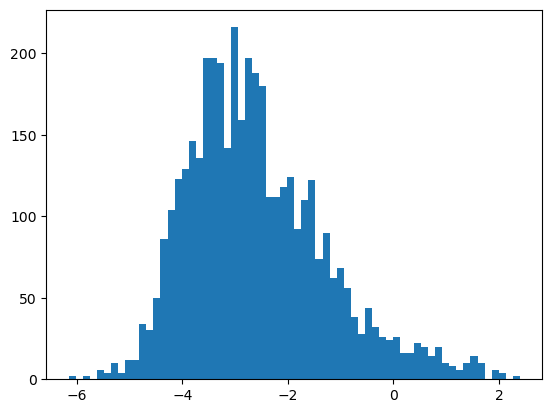

In [76]:
ax=plt.hist(np.log(imdat.flatten()),bins=64,density=False,)

In [78]:
!ls ./expfiles_0/

atom1.qxyz    cur.txt		 ising.log		latt2d_ZMC_96.inp
atom2.qxyz    diffuse.log	 ising2D_occ.txt	oxygen.zmat
carbon.zmat   diffuse_hk0_96.in  ising2D_seq.dat	zmc.log
contacts.all  err.log		 latt2d_ZMC_96.crystal
corr.out      hk0.bin		 latt2d_ZMC_96.diffuse


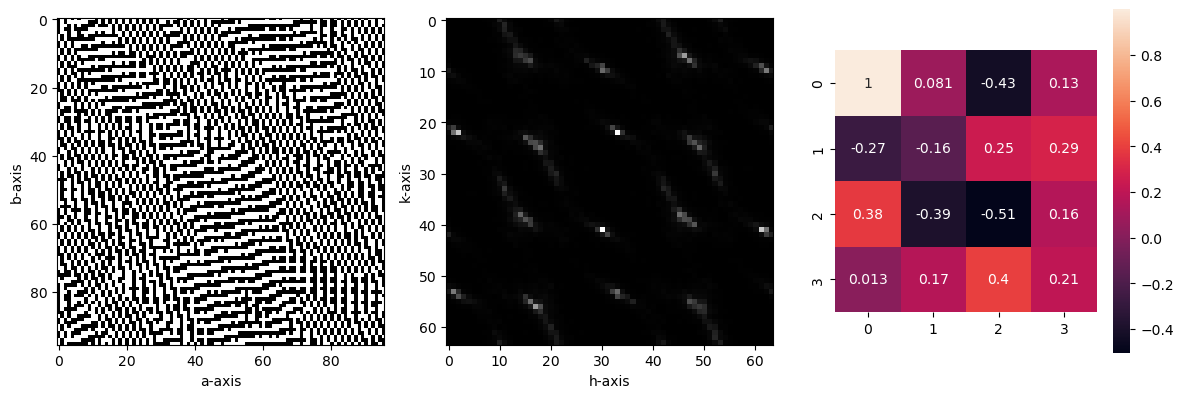

In [65]:
copyfile('expfiles_0/corr.out','./corr.in')
calc_diffuse_cfs4_big(iconc,1,icycles,ianneal,1)
store_occ_map_as_seq('./expfiles_1/ising2D_occ.txt','./expfiles_1/ising2D_seq.dat')
fig, axes = plt.subplots(1, 3, figsize=(12,4))
occ3D=get_occ_map('./expfiles_1/ising2D_occ.txt')
axes[0].imshow(np.transpose(occ3D[:,:,0]),interpolation='nearest',cmap='gray') 
axes[0].set_xlabel('a-axis')
axes[0].set_ylabel('b-axis')
imdat = read_bin('./expfiles_1/hk0.bin', npixels=64, offset=1280)
axes[1].imshow(np.flip(imdat,0),cmap='gray')
axes[1].set_xlabel('h-axis')
axes[1].set_ylabel('k-axis')
corr_out=np.loadtxt('expfiles_1/corr.out')
sns.heatmap(corr_out,ax=axes[2],annot=True,square=True,cbar_kws={'shrink':0.75})
plt.tight_layout()
# print(" 00: %.3f  01: %.3f  02: %.3f  03: %.3f\n 10: %.3f  11: %.3f  12: %.3f  13: %.3f\n 20: %.3f  21: %.3f  22: %.3f 23: %.3f \n 30: %.3f  31: %.3f  32: %.3f 33: %.3f \n"%tuple(corr_out.flatten()))

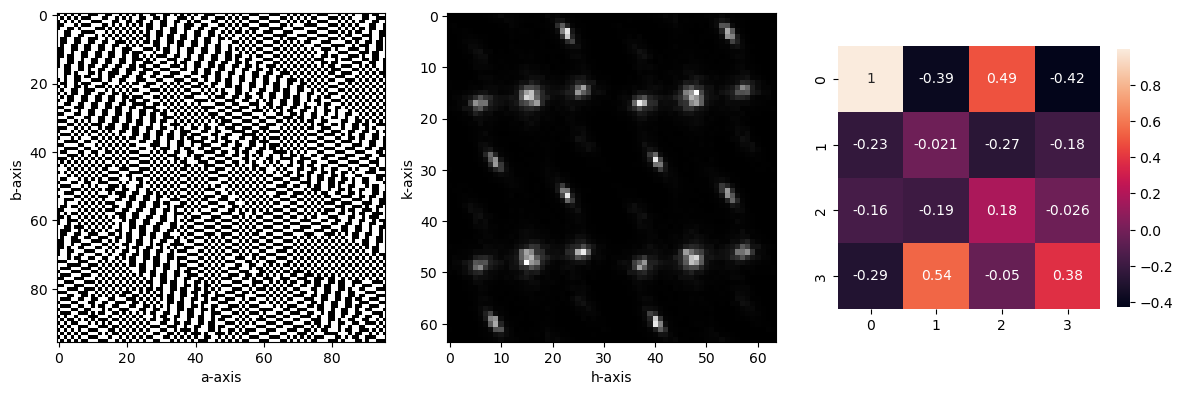

In [103]:
copyfile('expfiles_0/corr.out','./corr.in')
recalc_diff_from_other_cfs4_big(exp_source=0,exp_no=1)
store_occ_map_as_seq('./expfiles_1/ising2D_occ.txt','./expfiles_1/ising2D_seq.dat')
fig, axes = plt.subplots(1, 3, figsize=(12,4))
occ3D=get_occ_map('./expfiles_1/ising2D_occ.txt')
axes[0].imshow(np.transpose(occ3D[:,:,0]),interpolation='nearest',cmap='gray') 
axes[0].set_xlabel('a-axis')
axes[0].set_ylabel('b-axis')
imdat = read_bin('./expfiles_1/hk0.bin', npixels=64, offset=1280)
axes[1].imshow(np.flip(imdat,0),cmap='gray')
axes[1].set_xlabel('h-axis')
axes[1].set_ylabel('k-axis')
corr_out=np.loadtxt('expfiles_1/corr.out')
sns.heatmap(corr_out,ax=axes[2],annot=True,square=True,cbar_kws={'shrink':0.75})
plt.tight_layout()
# print(" 00: %.3f  01: %.3f  02: %.3f  03: %.3f\n 10: %.3f  11: %.3f  12: %.3f  13: %.3f\n 20: %.3f  21: %.3f  22: %.3f 23: %.3f \n 30: %.3f  31: %.3f  32: %.3f 33: %.3f \n"%tuple(corr_out.flatten()))

In [104]:
corr_out_0=np.loadtxt('expfiles_0/corr.out')
corr_out_1=np.loadtxt('expfiles_1/corr.out')
imdat_0 = read_bin('./expfiles_0/hk0.bin', npixels=64, offset=1280)
imdat_1 = read_bin('./expfiles_1/hk0.bin', npixels=64, offset=1280)
print("MSE correlation config: ", mean_squared_error(corr_out_0.flatten(),corr_out_1.flatten()))
print("MSE FT images: ", mean_squared_error(imdat_0.flatten(),imdat_1.flatten()))

MSE correlation config:  0.0
MSE FT images:  0.09638723


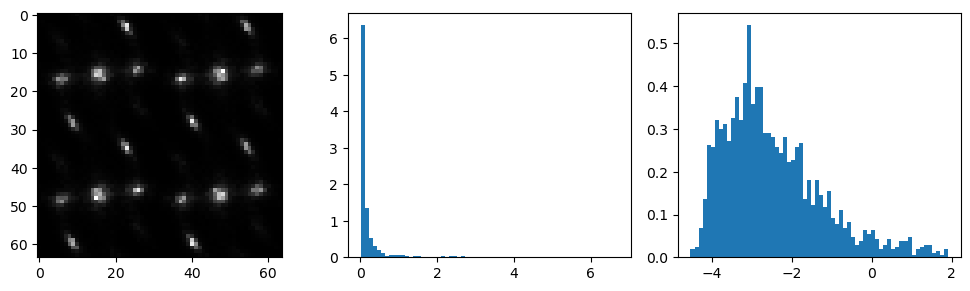

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(10,3))
ax1 = axes[0].imshow(np.flip(imdat_1,0), cmap='gray')
ax2 = axes[1].hist(imdat_1.flatten(), density=True, bins=64)
ax3 = axes[2].hist(np.log(imdat_1.flatten()+0.000001), density=True, bins=64)
plt.tight_layout()

In [ ]:
# %%timeit # you need to be careful with this becasue magic function acts like wrapper and screws with variable locality
# in fact its running the loop several times to get an average - if you want the time for a single run just import time
iconc=0.50 # spin concentration
cread=0    # reading correlation function from input file  otherwise it will be generated randomly 
icycles=500  # MC cycles 
ianneal=500  # MC input 

start_time = time.time()
# when possible always dump to a list or array before converting to Dataframe
N=5000 # make this many images
Nstart=0 # start labels here
corrfuncs=[]
for i in range(N):
    k=i+Nstart
    calc_diffuse_cfs4_big(iconc,0,icycles,ianneal,exp_no=0)
    copyfile('./expfiles_0/hk0.bin','./cfs4_big_image_inputs_bin/hk0_%s.bin'% str(k).zfill(6))
    store_occ_map_as_seq('./expfiles_0/ising2D_occ.txt','./cfs4_big_image_inputs_seq/ising2D_seq_%s.dat' %  str(k).zfill(6))
    # dont save the full occfile unless needed - since this takes up resources 
    # copyfile('./expfiles_0/ising2D_occ.txt','./image_inputs_occ/ising2D_occ_%d.txt'%(i))  
    corr_out=np.loadtxt('expfiles_0/corr.out')
    corrfuncs.append(corr_out.flatten())
    
end_time = time.time()
total_time = end_time - start_time

print("Total time taken: {:.2f} seconds".format(total_time))
df=pd.DataFrame(corrfuncs)
df.columns=['00','01','02','03','10','11','12','13','20','21','22','23','30','31','32','33']
df.to_csv('output_correlations_cfs4_big_5000.csv')
df.head()

In [2]:
# save the data as .h5
import numpy as np
import h5py
from latt2D_modules import plot_occ_map,read_bin,output_16bit_pgm

# Set the path to your images directory
img_dir = "./cfs4_big_image_inputs_bin/"

# Set the size of your images
img_size = (64, 64)

# Set the path to where you want to save the HDF5 file
h5_file = "./cfs4_big_image_dataset_5000.h5"

nfiles=5000
Nstart=0 
# Create a new HDF5 file
with h5py.File(h5_file, 'w') as hf:

    # Create a dataset to store your image data
    img_data = hf.create_dataset('cfs4_big_img_data', shape=(nfiles, *img_size), dtype=np.float64)

    # Loop through each image file
    for i in range(nfiles):    
        
        # Convert the image to a numpy array
        img_arr =read_bin(img_dir+'hk0_%s.bin'%str(i+Nstart).zfill(6), npixels=64, offset=1280)
        
        # Store the image data in the dataset
        img_data[i] = img_arr

# Print a message indicating the dataset has been created
print("Dataset created in {}".format(h5_file))


Dataset created in ./cfs4_big_image_dataset_5000.h5
